In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
from jaxopt import FixedPointIteration, ScipyMinimize, LBFGS

# Replication of Rust (1987) using Google's JAX 

This notebook rewrites the Rust (1987) optimal stopping problem using Google's JAX. I obtain a 4x speed-up compared to my previous notebook using Numba. I have only touched the surface of JAX's capabilities so I'm sure it's possible to attain an even faster solution!

The manual, raw data, and other code is located in the folder `nxfp` and was sourced from [here](https://zenodo.org/record/3385050#.YjTy3C-B1QI). 

## Part 1: Data manipulation

The data manipulation section remains the same as before.

The data is contained in ASCII files which must first be reshaped and then have the information contained in the first 11 rows be extracted.

The mileage given is the *accumulated* mileage, meaning it isn't reset to 0 after engine replacement. We will also create a separate dataset where mileage following the replacement has the mileage at replacement subtracted. Note that mileage *at the time of replacement* isn't set to 0, since the decision maker observes the total mileage at that time before deciding whether to replace.

In [2]:
# Import the raw data
b1_raw = pd.read_csv('nfxp/dat/g870.asc', header=None)
b1_raw = pd.DataFrame(b1_raw.values.reshape((15, int(len(b1_raw) / 15)))).T

b2_raw = pd.read_csv('nfxp/dat/rt50.asc', header=None)
b2_raw = pd.DataFrame(b2_raw.values.reshape((4, int(len(b2_raw) / 4)))).T

b3_raw = pd.read_csv('nfxp/dat/t8h203.asc', header=None)
b3_raw = pd.DataFrame(b3_raw.values.reshape((48, int(len(b3_raw) / 48)))).T

b4_raw = pd.read_csv('nfxp/dat/a530875.asc', header=None)
b4_raw = pd.DataFrame(b4_raw.values.reshape((37, int(len(b4_raw) / 37)))).T

In [3]:
def extract_info(b):

    # Create separate dataframe for bus info
    new_index = ['' for x in range(11)]
    new_index[0] = 'bus_number'
    new_index[1] = 'month_purchased'
    new_index[2] = 'year_purchased'
    new_index[3] = 'month_replacement_1'
    new_index[4] = 'year_replacement_1'
    new_index[5] = 'odometer_replacement_1'
    new_index[6] = 'month_replacement_2'
    new_index[7] = 'year_replacement_2'
    new_index[8] = 'odometer_replacement_2'
    new_index[9] = 'month_begin'
    new_index[10] = 'year_begin'
    b_info = b.iloc[:11]
    b_info.index = new_index
    b_info = b_info.T.set_index('bus_number').T
    
    # Set bus number to be column headers
    b = b.T.set_index([0]).T

    # Drop bus info
    b = b[10:]

    # Add dates to row index
    month = b_info.loc["month_begin"].values[0]
    year = b_info.loc["year_begin"].values[0]
    b.index = pd.date_range(f"{year}-{month}-01", periods=len(b), freq="MS")

    # Fix month and years of odometer replacements to be date corresponding to odometer replacement
    # Rust points out this differs in some cases
    col_map = pd.DataFrame(b.columns).to_dict()[0]
    for o in ['1', '2']:
        x, y = np.where(b > b_info.loc[f'odometer_replacement_{o}', :])
        replacement = pd.DataFrame([x, y], index=['row', 'column']).T
        replacement = replacement.groupby('column').min()
        replacement.index = replacement.index.map(col_map)
        replacement[f'month_{o}'] = replacement['row'].apply(lambda x: b.index[x].month)
        replacement[f'year_{o}'] = replacement['row'].apply(lambda x: np.mod(b.index[x].year, 1900))
        replacement[f'replace_{o}'] = replacement['row'].apply(lambda x: pd.Timestamp(year=b.index[x].year, month=b.index[x].month, day=1))
        replacement[replacement.row == 0] = 0
        # Append checks to dataframe
        replacement = replacement.drop('row', axis=1)
        b_info = pd.concat([b_info, replacement.T])

    return b_info, b

In [4]:
def update_b(b, b_info):
    '''Resets mileage after replacement and returns investment decision matrix'''

    b_reset = b.copy()
    b_i = b.copy()
    b_i[:] = 0  # Set default decision to i = 0

    # Iterate through each bus in the dataset
    for col in b.iteritems():

        bus_number = col[0]
        bus_info = b_info[bus_number].copy()

        # Iterate through replacement 1 and 2
        for r in ('1', '2'):
            replace_date = bus_info[f'replace_{r}']
            if replace_date != 0:

                if r == '1':
                    odometer_replacement = b.loc[replace_date, bus_number]

                if r == '2':
                    # Subtract mileage from replacement 1
                    replace_date_1 = bus_info[f'replace_1']
                    previous_mileage = b.loc[replace_date_1, bus_number]
                    odometer_replacement = b.loc[replace_date, bus_number] - previous_mileage
                
                bus_odometer = b_reset[bus_number].copy()
                
                # Find replacement date then subtract odometer replacement value from
                # odometer readings after replacement
                bus_odometer[bus_odometer.index > replace_date] -= odometer_replacement
                b_reset[bus_number] = bus_odometer

                # Set decision = 1 on replacement date
                b_i.loc[replace_date, bus_number] = 1

    return b, b_reset, b_i

In [5]:
def discretize(b, d=5000):
    '''Discretizes odometer data into buckets of length d'''

    return np.floor(b / d)

In [6]:
# Extract information from the raw datasets
b1_info, b1 = extract_info(b1_raw)
b2_info, b2 = extract_info(b2_raw)
b3_info, b3 = extract_info(b3_raw)
b4_info, b4 = extract_info(b4_raw)

# Get relevant data and merge
b1, b1_reset, b1_i = update_b(b1, b1_info)
b2, b2_reset, b2_i = update_b(b2, b2_info)
b3, b3_reset, b3_i = update_b(b3, b3_info)
b4, b4_reset, b4_i = update_b(b4, b4_info)

b = pd.concat([b1, b2, b3, b4], axis=1, join='outer')
b_reset = pd.concat([b1_reset, b2_reset, b3_reset, b4_reset], axis=1, join='outer')
b_i = pd.concat([b1_i, b2_i, b3_i, b4_i], axis=1, join='outer')

# Create dataframe for likelihood estimation
b_data = pd.concat([discretize(b_reset.T.stack()), b_i.T.stack()], axis=1)
b_data.columns = ['state', 'decision']


The transition probabilities are found by discretizing the data set into intervals of length 5000. The transition states $d$ are given as
$$
d=
\begin{cases}
0 \quad \Delta mileage \in [0, 5000) \\
1 \quad \Delta mileage \in [5000, 10000) \\
2 \quad \Delta mileage \in [10000, \infty)
\end{cases}
$$

Then the empirical frequency of $d$ gives the transition probabilities.

In [7]:
# Discretize the odometer readings
b_discrete = discretize(b)

# Calculate the states d = {0, 1, 2}
b_state = b_discrete - b_discrete.shift(1)

# Find the transition probabilities
N = b_state.notna().sum().sum()
p = (b_state == 0).sum().sum() / N
q = (b_state == 1).sum().sum() / N
(p, q)

(0.35102991662579697, 0.6374448258950466)

## Part 2: Setting up the model

The JAX library requires a more functional appproach to programming. Unlike Numba, we won't use a class to store parameters, but rather they will be inputs into our functions. Here I define functions to construct the transition matrix using the empirical frequencies above and the utility function.

In [8]:
def get_P(p, q, T=90):
    '''Transition matrix'''

    # Construct transition matrix
    P = jnp.zeros((T, T))
    P += jnp.diag(np.ones(T) * p, 0)
    P += jnp.diag(np.ones(T - 1) * q, 1)
    P += jnp.diag(np.ones(T - 2) * (1 - p - q), 2)

    # Adjust so each row sums to 1
    P = P.at[:, -1].set(P[:, -1] + (1 - P.sum(1)))
    
    return P

In [9]:
@jit
def u(x, i, θ, scale=0.001):
    '''Utility function'''

    θ_1, RC = θ

    # Cost to maintain x mileage
    c = scale * θ_1 * x

    # Pay fixed cost RC only if i == 1
    u = -c - RC * i

    return u

## Part 3: Solving the inner loop

The inner loop is a straight-forward dynamic programming problem which does not depend on the data.

Note that the number of iterations in each loop is high, so `maxiter` should be set to a large number. To avoid overflow issues in the exponential function, the current expected value is subtracted from the conditional values, and then re-added after taking the log of the exponential.

In [10]:
@jit
def W(EV, θ, p, q, β=0.9999):
    '''Bellman operator'''

    # Transition matrix
    P = get_P(p, q)
    T = P.shape[0]
    
    # Grid of mileage
    x = jnp.arange(T)

    # Utilities 
    wait = u(x, 0, θ) + β * EV
    replace = u(x[0], 1, θ) + β * EV[0]
    EV_new = jnp.exp(replace - EV) + jnp.exp(wait - EV)
    EV_new = P @ (jnp.log(EV_new) + EV)

    return EV_new

I use JAX's optimization library to find the fixed point in the inner loop.

In [11]:
@jit
def inner_loop(θ, p, q, β=0.9999):
    '''Solve for the fixed point of the Bellman operator'''

    # Transition matrix
    P = get_P(p, q)
    T = P.shape[0]

    fpi = FixedPointIteration(fixed_point_fun=W, maxiter=200_000)
    EV_init = jnp.zeros(T)
    EV_star = fpi.run(EV_init, θ, p, q)

    return EV_star.params

Here is what the solution of the inner loop looks like given some starting values.

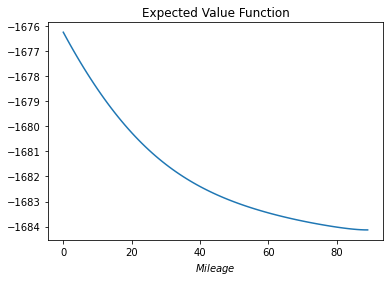

In [12]:
# Guess of parameters
θ = jnp.array([3.6, 10])

plt.plot(inner_loop(θ, p, q))
plt.title('Expected Value Function')
plt.xlabel('$Mileage$')
plt.show()

## Part 4: Solving the outer loop

The outer loop solves for the parameters using maximum likelihood estimation.

Given some parameters, we find the solution to the dynamic programming problem and use the expected values to calculate the conditional probability of waiting or replacing the engine. Then using our data, we construct the log likelihood function by summing up the conditional probability that corresponds to the state and decision for each observation. As such, the only data needed is the decision $i$ and state $x$. The state is the discretized mileage accounting for previous engine replacements.

Here is what the dataframe looks like:

In [13]:
b_data.head()

state  decision
0                               
4403 1983-05-01    0.0       0.0
     1983-06-01    0.0       0.0
     1983-07-01    1.0       0.0
     1983-08-01    2.0       0.0
     1983-09-01    3.0       0.0

The formula for conditional probabilities results from the assumption that the errors are Gumbel distributed.

$$
Pr(i|x, \theta) = \frac{exp(u(x, i, \theta_1) + \beta EV(x, i))}{\sum_j exp(u(x, j, \theta_1) + \beta EV(x, j))}
$$


In [14]:
@jit
def cond_prob(x, EV, θ, β):
    '''Find the conditional probabilities for each x and i'''
    
    wait = u(x, 0, θ) + β * EV
    replace = u(x[0], 1, θ) + β * EV[0]
    P_wait = 1 / (1 + jnp.exp(replace - wait))
    P_replace = 1 - P_wait

    return P_wait, P_replace

The log-likelihood function first solves the inner loops to find the expected value given the parameters, then returns the negative of the log-likelihood to minimize.

In [15]:
def log_likelihood(θ,             # Parameters to search over
                   decisions,     # Array of decisions i = {0, 1}
                   states,        # Array of states x = {0, 1, ..., 89}
                   p,             # Absorbing state probability
                   q,             # Transition state 1 probability
                   β=0.9999):

    # Solve inner loop
    EV = inner_loop(θ, p, q)

    # Mileage states
    T = EV.shape[0]
    x = jnp.arange(T)

    # Conditional probabilities
    P_wait, P_replace = cond_prob(x, EV, θ, β)

    # Construct mapping from data (x, i) to log conditional probabilities
    @vmap
    def get_logL(x, i):
        cond_prob = (i == 0) * P_wait[x] + (i == 1) * P_replace[x]
        return jnp.log(cond_prob)

    # Likelihood is the sum of conditional probabilities for each (x, i)
    logL = get_logL(states, decisions).sum()
    return -logL

Using JAX's optimization library, I sped up the outer loop around 4x compared to using Numba.

In [20]:
%%time
# Convert data is JAX arrays
decisions = jnp.array(b_data.decision, dtype=int)
states = jnp.array(b_data.state, dtype=int)

# Solve the outer loop
outer_loop = ScipyMinimize(fun=log_likelihood, method="Nelder-Mead")
θ_init = jnp.array([0.1, 10], dtype=float)
results = outer_loop.run(θ_init, decisions, states, p, q)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


CPU times: user 9.62 s, sys: 105 ms, total: 9.73 s
Wall time: 9.82 s


Also, the solution is now even closer to what was printed in Rust's original paper:

In [21]:
θ_star = results.params
θ_star

DeviceArray([2.5854068, 9.76613  ], dtype=float32)

## Part 5: Plotting the results

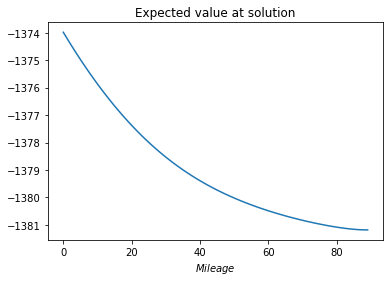

In [22]:
# Use the solution to set up a new model
EV_star = inner_loop(θ_star, p, q)
x = np.arange(len(EV_star))

plt.plot(EV_star)
plt.title('Expected value at solution')
plt.xlabel('$Mileage$')
plt.show()

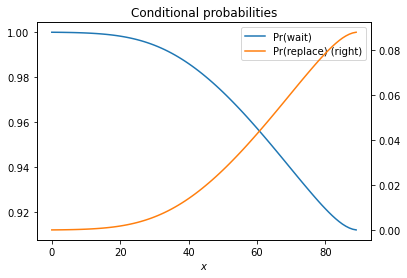

In [23]:
P_wait, P_replace = cond_prob(x, EV_star, θ_star, β=0.9999)
P_star = pd.DataFrame([np.asarray(P_wait), np.asarray(P_replace)]).T
P_star.iloc[:, 0].plot(label='Pr(wait)', legend=True, title='Conditional probabilities', xlabel='$x$')
P_star.iloc[:, 1].plot(secondary_y=True, label='Pr(replace)', legend=True)
plt.show()